In [1]:
from reader import readShortVideo
from reader import getVideoList
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from os import listdir
import os
import pandas as pd
import numpy as np
import pickle

import torchvision
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
%matplotlib inline
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
# load features 
with open("../features/train_cut_features_350.pkl", "rb") as f:
    train_cut_features = pickle.load(f)
with open("../features/train_cut_labels_350.pkl", "rb") as f:
    train_cut_labels = pickle.load(f)
with open("../features/train_cut_lengths_350.pkl", "rb") as f:
    train_cut_lengths = pickle.load(f)
    
with open("../features/valid_cut_features_no_cut.pkl", "rb") as f:
    valid_cut_features = pickle.load(f)
with open("../features/valid_cut_labels_no_cut.pkl", "rb") as f:
    valid_cut_labels = pickle.load(f)
with open("../features/valid_cut_lengths_no_cut.pkl", "rb") as f:
    valid_cut_lengths = pickle.load(f)    

In [3]:
weights = torch.load("../models/RNN_FC_model.pkt")

In [3]:
class seq2seq(nn.Module):
    def __init__(self, input_size, hidden_size=512, n_layers=2, dropout=0.1):
        super(seq2seq, self).__init__()
        self.hidden_size =  hidden_size
        self.lstm = nn.LSTM(input_size, self.hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=False,
                           batch_first=True)
        self.bn_0 = nn.BatchNorm1d(self.hidden_size)
        self.fc_1 = nn.Linear(self.hidden_size, int(self.hidden_size/2))
        self.bn_1 = nn.BatchNorm1d(int(self.hidden_size/2))
        self.fc_2 = nn.Linear(int(self.hidden_size), 11)
        self.softmax = nn.Softmax(1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
    def forward(self, padded_sequence, input_lengths, hidden=None):
        packed = torch.nn.utils.rnn.pack_padded_sequence(padded_sequence, 
                                                         input_lengths, 
                                                         batch_first=True)
        outputs, (hn,cn) = self.lstm(packed, hidden) # output: (seq_len, batch, hidden*n_dir)
        
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)

        fc_output = self.fc_2(outputs)
        return fc_output

In [4]:
def sort_pad(input_feature, input_lengths, input_labels):
    perm_index = np.argsort(input_lengths)[::-1]
    input_feature =  [input_feature[i] for i in perm_index]
    input_labels =  [input_labels[i] for i in perm_index]
    input_lengths = sorted(input_lengths, reverse=True)
    input_feature = nn.utils.rnn.pad_sequence(input_feature, batch_first=True)
    return input_feature, input_labels, input_lengths

In [5]:
class Loss(nn.Module):
    def __init__(self):
        super(Loss, self).__init__()

    def forward(self, model_output, groundtruth, lengths):
        
        criterion = nn.CrossEntropyLoss()
        loss = 0
        batch_size = model_output.size()[0]

        for i in range(batch_size):
            sample_length = lengths[i]
            target = groundtruth[i].type(torch.LongTensor).cuda()
            prediction = model_output[i][:sample_length]
            partial_loss = criterion(prediction, target)
            loss += partial_loss
        loss = loss / batch_size

        return loss

In [7]:
feature_size = 1024*7*7
model = seq2seq(feature_size,hidden_size=512,dropout=0.5, n_layers=2).cuda()
# model.load_state_dict(weights)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
BATCH_SIZE = 32
loss_function = Loss().cuda()
max_accuracy = 0
model.train()
for epoch in range(20):
    print("Epoch:", epoch+1)
    CE_loss = 0.0
    total_length = len(train_cut_features)
    # shuffle
    perm_index = np.random.permutation(total_length)
    train_X_sfl = [train_cut_features[i] for i in perm_index]
    train_y_sfl = [train_cut_labels[i] for i in perm_index]
    train_lengths_sfl = np.array(train_cut_lengths)[perm_index]
    # construct training batch
    for index in range(0,total_length ,BATCH_SIZE):
        if index+BATCH_SIZE > total_length:
            break
            
        # zero the parameter gradients
        optimizer.zero_grad()
        input_X = train_X_sfl[index:index+BATCH_SIZE]
        input_y = train_y_sfl[index:index+BATCH_SIZE]
        input_lengths = train_lengths_sfl[index:index+BATCH_SIZE]
        input_X, input_y, input_lengths = sort_pad(input_X, input_lengths, input_y)
        # use GPU
#         input_X = torch.nn.utils.rnn.pad_sequence(input_X).cuda()
        # forward + backward + optimize
        output = model(input_X.cuda(), input_lengths)
        # compute loss for each sample in training data
        loss = loss_function(output, input_y,input_lengths)
        loss.backward()
        optimizer.step()
        CE_loss += loss.cpu().data.numpy()
    print("training loss",CE_loss)
    
    # validation
    same_difference = []
    with torch.no_grad():
        model.eval()
        valid_output = []
        valid_y_list = []
        for valid_X, valid_y, valid_lengths in zip(valid_cut_features, valid_cut_labels, 
                                                   valid_cut_lengths):
            input_valid_X = valid_X.unsqueeze(0)
            output = model(input_valid_X.cuda(), [valid_lengths])
            prediction = torch.argmax(torch.squeeze(output.cpu()),1).data.numpy()
            print(sum(prediction!=0))
            valid_gt = np.array(valid_y)
            same_difference.append(prediction==valid_gt)

        total = []
        for i in same_difference:
            total+=list(i)
        accuracy = np.mean(total)
        print("validation accuracy: ",accuracy)
    if accuracy > max_accuracy:
        max_accuracy = accuracy
#         torch.save(model.state_dict(), "../models/RNN_seq2seq_model.pkt")
    model.train()

Epoch: 1
training loss 8.909528017044067
0
0
0
0
0
validation accuracy:  0.4660878112712975
Epoch: 2
training loss 7.338753819465637
0
0
0
0
0
validation accuracy:  0.4660878112712975
Epoch: 3
training loss 6.929655313491821
0
0
0
0
0
validation accuracy:  0.4660878112712975
Epoch: 4
training loss 6.6451791524887085
0
0
0
0
17
validation accuracy:  0.468872870249017
Epoch: 5
training loss 6.36333692073822
59
1
43
12
67
validation accuracy:  0.48394495412844035
Epoch: 6
training loss 5.989698171615601
298
1
45
66
69
validation accuracy:  0.5044233289646134
Epoch: 7
training loss 5.72145676612854
766
101
185
197
105
validation accuracy:  0.5370249017038008
Epoch: 8
training loss 5.437108635902405
801
102
173
212
105
validation accuracy:  0.5511140235910879
Epoch: 9
training loss 5.143192648887634
778
77
153
208
91
validation accuracy:  0.5558650065530799
Epoch: 10
training loss 4.802034616470337
766
82
168
211
104
validation accuracy:  0.5548820445609436
Epoch: 11
training loss 4.5296788

# inference

In [6]:
feature_size = 1024*7*7
model = seq2seq(feature_size,hidden_size=512,dropout=0.5, n_layers=2).cuda()
model.load_state_dict(torch.load("../models/RNN_seq2seq_model.pkt"))

In [7]:
with torch.no_grad():
    model.eval()
    valid_output = []
    for valid_X, valid_lengths in zip(valid_cut_features, valid_cut_lengths):
        input_valid_X = valid_X.unsqueeze(0)
        output = model(input_valid_X.cuda(), [valid_lengths])
        prediction = torch.argmax(torch.squeeze(output.cpu()),1).data.numpy()
        valid_output.append(prediction)

In [8]:
valid_dir_name = sorted(listdir("../HW5_data/FullLengthVideos/videos/valid"))

In [ ]:
valid_dir_name

In [29]:
output_folder = "../output/"
for i in range(len(valid_dir_name)):
    with open(os.path.join(output_folder, valid_dir_name[i]+'.txt'), "w") as f:
        for j, pred in enumerate(valid_output[i]):
            f.write(str(pred))
            if j != len(valid_output[i])-1:
                f.write("\n")

# visualization

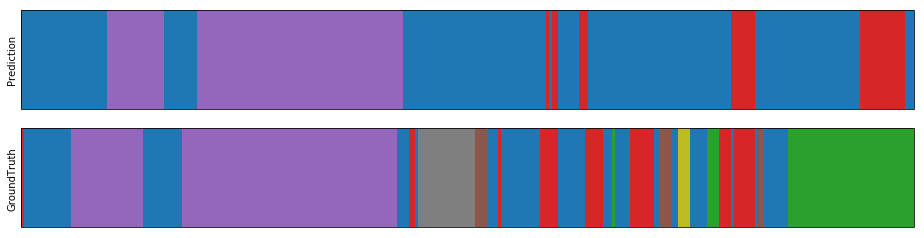

In [20]:
# reference: https://matplotlib.org/2.0.2/examples/api/colorbar_only.html
video_num = 4
test = valid_output[video_num][544:844]
answer = valid_cut_labels[video_num][544:844]
plt.figure(figsize=(16,4))
ax = plt.subplot(211)

# colors = ["wheat", "turqoise", "teal", "sienna", "salmon", "orange", 
#           "lightblue", "lavender", "gold", "darkblue", "azure"]
colors = plt.cm.get_cmap('tab20',11).colors
cmap = matplotlib.colors.ListedColormap([colors[idx] for idx in test])
# cmap = plt.cm.get_cmap("tab20", 11)
bounds = [i for i in range(len(test))]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,
                                       norm=norm,
                                       boundaries=bounds,
                                       spacing='proportional',
                                       orientation='horizontal',
                                       ticks= range(544,844))
ax.set_ylabel('Prediction')

ax2 = plt.subplot(212)
cmap = matplotlib.colors.ListedColormap([colors[idx] for idx in answer])
bounds = [i for i in range(len(test))]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb2 = matplotlib.colorbar.ColorbarBase(ax2, cmap=cmap,
                                       norm=norm,
                                       boundaries=bounds,
                                       spacing='proportional',
                                       orientation='horizontal',
                                       ticks= list(range(544,844)))


ax2.set_ylabel('GroundTruth')

plt.savefig("temporal_action_segmentation.png")
plt.show()